In [1]:
%matplotlib inline

import warnings
from collections import Counter
import numpy as np
warnings.filterwarnings('ignore')
import networkx as nx
import pandas as pd
from cdlib import algorithms, ensemble, evaluation, viz, NodeClustering, TemporalClustering
from networkx.generators.community import LFR_benchmark_graph
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import plotly.graph_objects as go

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'karateclub', 'graph_tool'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer'}


In [2]:
def w_graph_creation(csv):
    df = pd.read_csv(csv)
    
    #creo grafo
    G = nx.Graph()
    
    #creo nodi e info
    for i in df.index:
        if df['User'][i] not in G.nodes():
            G.add_node(df['User'][i], follower = (df['Follows_Count'][i]), 
                    friends = (df['Friends_Count'][i]), semester = (df['Semester'][i]),
                    u_label = (df['user_label'][i]))
    
    #creo link pesati
    df_w = df.groupby(['User','In_reply_To'],as_index=False).size().sort_values('size',ascending=False)
    for i in df_w.index:
        G.add_edge(df_w['User'][i], df_w['In_reply_To'][i], weight= df_w['size'][i])
    
    return G


def clustering_evaluation(method):
    print('Evaluating: ' + str(method.method_name))
    print("Node coverage: ", method.node_coverage)
    print("Overlapping: ", method.overlap)
    print("N_communities: ", len(method.communities))
    print("Number of nodes: ", method.size())
    print("Average internal degree: ", method.average_internal_degree())
    print("Internal edge density: ", method.internal_edge_density())
    print("Conductance: ", method.conductance())
    print("Cut ratio: ", method.cut_ratio())
    print("Newman Girvan modularity: ", method.newman_girvan_modularity())
    return
    
def clustering_comparator_AMI(method, list_of_methods): #Adjusted_Mutual_Information
    for methods in list_of_methods:
        eval = evaluation.normalized_mutual_information(method, methods)
        print('Comparison between ' + str(method.method_name) +' and ' + str(methods.method_name) + ' using Adjusted Mutual Information \n' + str(eval) +'\n')
    return

def clustering_comparator_ONMI(method, list_of_methods): #Overlapping_Normalized_Mutual_Information_LFK
    for methods in list_of_methods:
        eval = evaluation.overlapping_normalized_mutual_information_LFK(method, methods)
        print('Comparison between ' + str(method.method_name) +' and ' + str(methods.method_name) + ' using Overlapping Normalized Mutual Information LFK \n' + str(eval) +'\n')
    return

def modularity_vs_conductance(graph, lower_range, upper_range, algorithm):
    n_com = []
    condu = []
    modu = []
    for i in range(lower_range, upper_range):
        coms = algorithm(graph, i)
        n_com.append(i)
        condu.append(coms.conductance()[2])
        modu.append(coms.newman_girvan_modularity()[2])

    plt.plot(n_com, condu, '-g', label='conductance')
    plt.plot(n_com, modu, '-b', label='modularity')
    plt.legend();
    
    return

In [3]:
G1 = w_graph_creation('../../data_collection/data/RW_Graphs/df_S1.csv')
G2 = w_graph_creation('../../data_collection/data/RW_Graphs/df_S2.csv')
G3 = w_graph_creation('../../data_collection/data/RW_Graphs/df_S3.csv')
G4 = w_graph_creation('../../data_collection/data/RW_Graphs/df_S4.csv')

In [4]:
g = [G1, G2, G3, G4]
for graph in g:
    conn_comps = sorted(nx.connected_components(graph), key=len, reverse=True) 
    graph.remove_nodes_from([n for n in graph if n not in set(conn_comps[0])])

In [5]:
len(G1)

17440

In [6]:
len(G2)

17387

In [7]:
len(G3)

10090

In [8]:
len(G4)

18205

In [20]:
user1 = list(G1.nodes())

In [21]:
user2 = list(G2.nodes())

In [22]:
user3 = list(G3.nodes())

In [23]:
user4 = list(G4.nodes())

In [24]:
jaccard(user1, user2)

0.16229475370444532

In [25]:
jaccard(user2, user3)

0.14059775840597757

In [26]:
jaccard(user3, user4)

0.1368932819029251

In [27]:
jaccard(user1, user4)

0.11282819768349411

In [9]:
tc = TemporalClustering()
t = 1


for graph in g:
    coms = algorithms.leiden(graph, weights = 'weight')
    tc.add_clustering(coms, t)
    print(len(tc.get_clustering_at(t).communities))   
    t = t+1

60
38
46
35


Guardo alla stabilità delle comunità

In [10]:
trend = tc.clustering_stability_trend(evaluation.nf1)
trend

[0.0019144736842105264, 0.0004930309964634908, 0.0019248798781202388]

snapshots’ node clustering matching

In [11]:
jaccard = lambda x, y: len(set(x) & set(y)) / len(set(x) | set(y))

In [12]:
com_polytree = tc.lifecycle_polytree(jaccard, two_sided=False)
print(com_polytree)

DiGraph with 179 nodes and 1445 edges


Visualizzazione evoluzione comunità

In [13]:
weak_comp = list(nx.weakly_connected_components(com_polytree))[0]
x = com_polytree.copy()
x.remove_nodes_from([n for n in com_polytree.nodes() if n not in weak_comp])

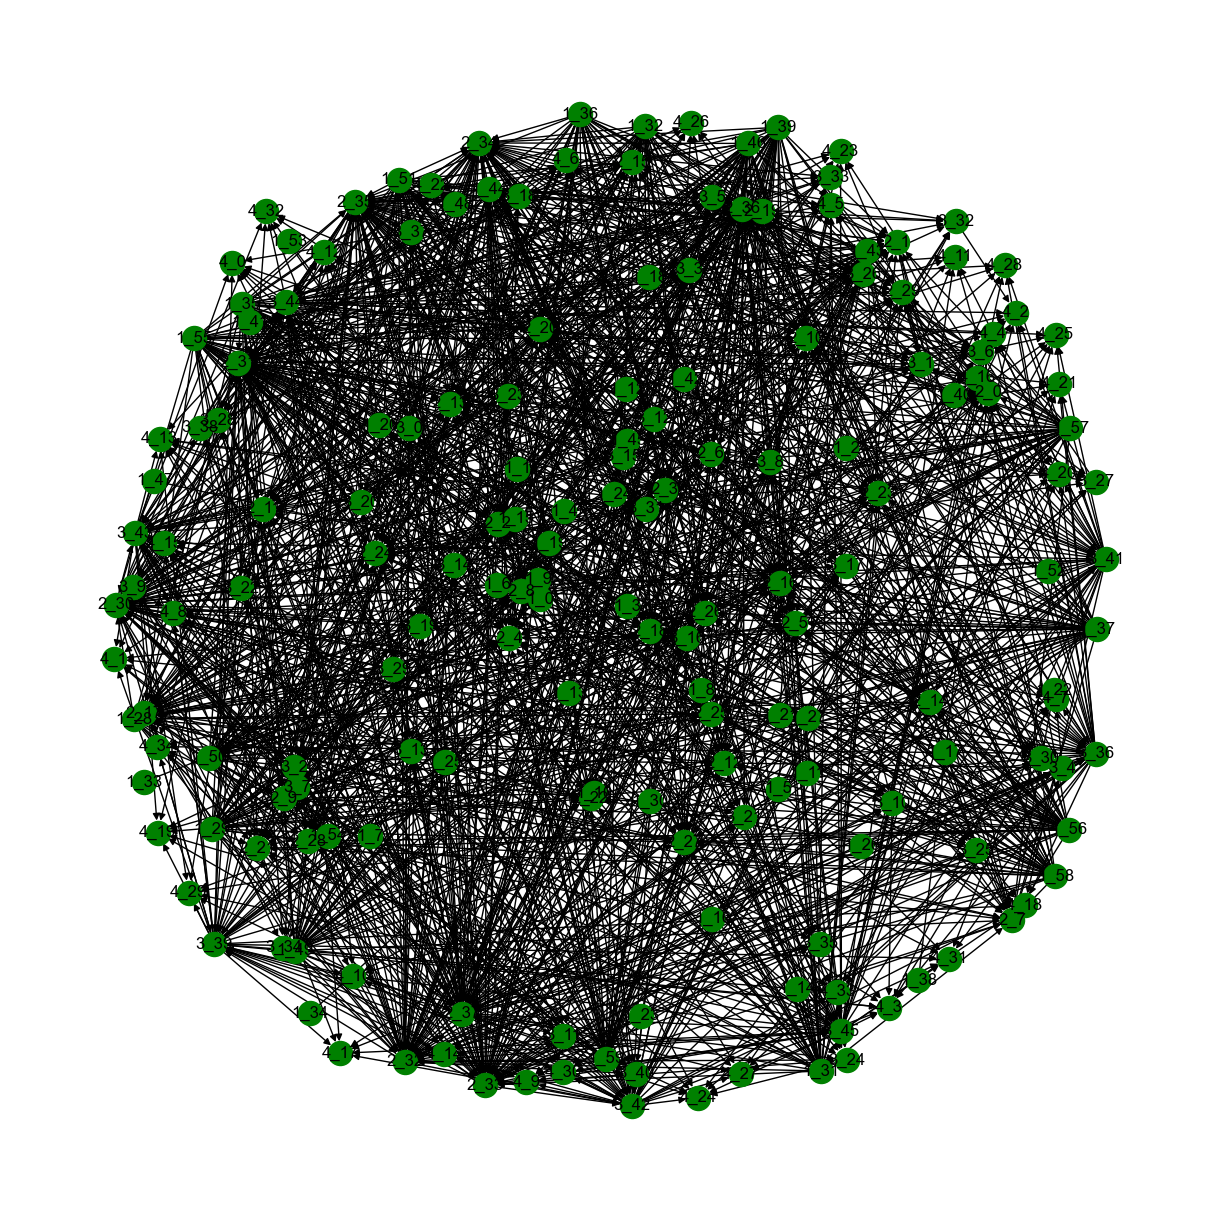

In [14]:
plt.figure(3,figsize=(12,12)) 
nx.draw(x, pos=nx.spring_layout(x), with_labels=True, node_color = "green") 

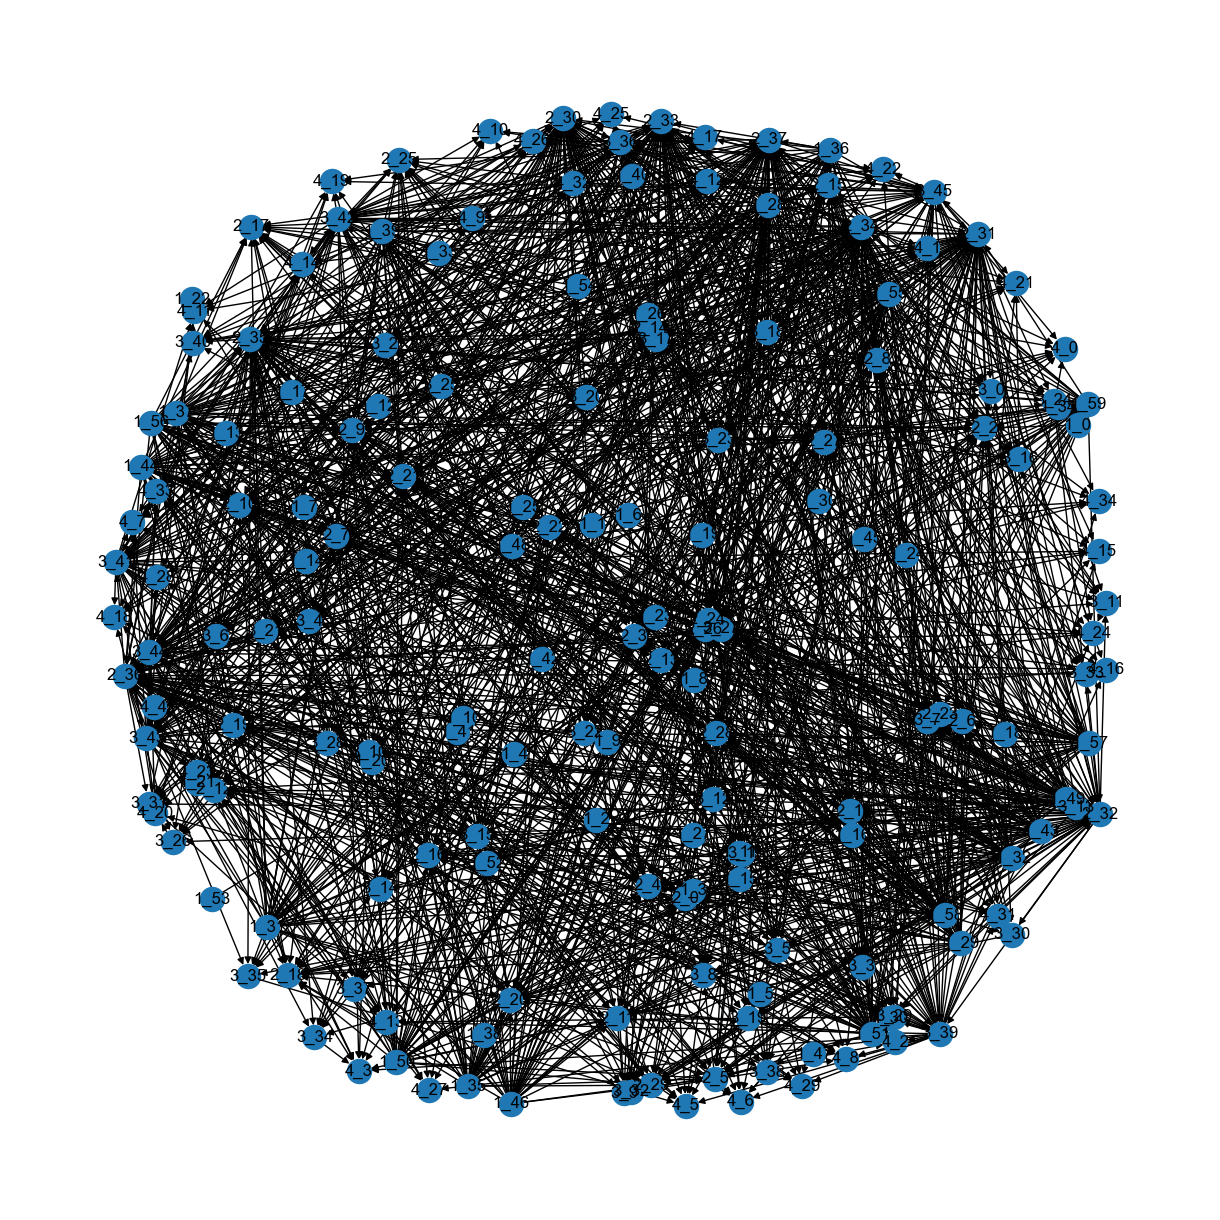

In [15]:
for nodes in nx.weakly_connected_components(com_polytree):
    sub =  com_polytree.subgraph(nodes)    
    plt.figure(3,figsize=(12,12)) 
    nx.draw(sub, pos=nx.spring_layout(sub), with_labels=True) 

In [16]:
list(nx.weakly_connected_components(com_polytree))

[{'1_0',
  '1_1',
  '1_10',
  '1_11',
  '1_12',
  '1_13',
  '1_14',
  '1_15',
  '1_16',
  '1_17',
  '1_18',
  '1_19',
  '1_2',
  '1_20',
  '1_21',
  '1_22',
  '1_23',
  '1_24',
  '1_25',
  '1_26',
  '1_27',
  '1_28',
  '1_29',
  '1_3',
  '1_30',
  '1_31',
  '1_32',
  '1_33',
  '1_34',
  '1_35',
  '1_36',
  '1_37',
  '1_38',
  '1_39',
  '1_4',
  '1_40',
  '1_41',
  '1_42',
  '1_43',
  '1_44',
  '1_45',
  '1_46',
  '1_47',
  '1_48',
  '1_49',
  '1_5',
  '1_50',
  '1_51',
  '1_52',
  '1_53',
  '1_54',
  '1_55',
  '1_56',
  '1_57',
  '1_58',
  '1_59',
  '1_6',
  '1_7',
  '1_8',
  '1_9',
  '2_0',
  '2_1',
  '2_10',
  '2_11',
  '2_12',
  '2_13',
  '2_14',
  '2_15',
  '2_16',
  '2_17',
  '2_18',
  '2_19',
  '2_2',
  '2_20',
  '2_21',
  '2_22',
  '2_23',
  '2_24',
  '2_25',
  '2_26',
  '2_27',
  '2_28',
  '2_29',
  '2_3',
  '2_30',
  '2_31',
  '2_32',
  '2_33',
  '2_34',
  '2_35',
  '2_36',
  '2_37',
  '2_4',
  '2_5',
  '2_6',
  '2_7',
  '2_8',
  '2_9',
  '3_0',
  '3_1',
  '3_10',
  '3_11',
  

### Tuning principled clustering

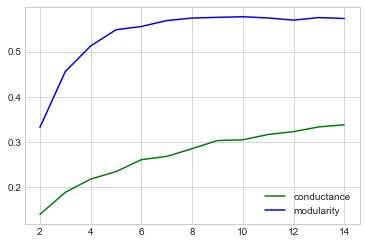

In [15]:
modularity_vs_conductance(G1, 2, 15, algorithms.principled_clustering)

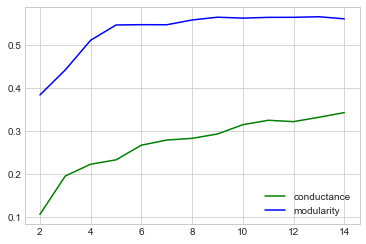

In [16]:
modularity_vs_conductance(G2, 2, 15, algorithms.principled_clustering)

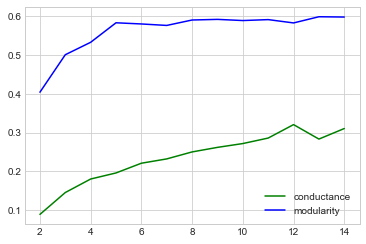

In [17]:
modularity_vs_conductance(G3, 2, 15, algorithms.principled_clustering)

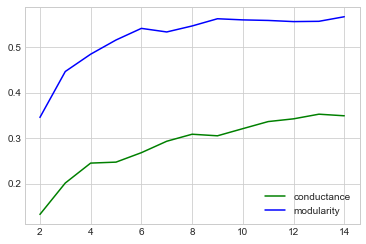

In [18]:
modularity_vs_conductance(G4, 2, 15, algorithms.principled_clustering)

Cluster_Count per t:                 
t1: 8               
t2: 9                
t3: 8              
t4: 9

In [28]:
tc = TemporalClustering()
t = 1


for graph in g:
    cluster_c = input('Give me cluster_count: ')
    coms = algorithms.principled_clustering(graph, cluster_count = int(cluster_c))
    tc.add_clustering(coms, t)
    print(len(tc.get_clustering_at(t).communities))   
    t = t+1

Give me cluster_count:  8


8


Give me cluster_count:  9


9


Give me cluster_count:  8


8


Give me cluster_count:  9


9


In [29]:
tc.get_observation_ids()

[1, 2, 3, 4]

In [180]:
trend = tc.clustering_stability_trend(evaluation.nf1)
trend

[0.0073437500000000005, 0.016666666666666666, 0.010277777777777776]

In [181]:
jaccard = lambda x, y: len(set(x) & set(y)) / len(set(x) | set(y))

In [182]:
matches = tc.community_matching(jaccard, two_sided=True)

In [183]:
f"Example of community match: {matches[0]}"

"Example of community match: ('1_0', '2_1', 0.05863292701743558)"

In [184]:
com_polytree = tc.lifecycle_polytree(jaccard, two_sided=False)
print(com_polytree)

DiGraph with 31 nodes and 25 edges


In [185]:
weak_comp = list(nx.weakly_connected_components(com_polytree))[1]
x = com_polytree.copy()
x.remove_nodes_from([n for n in com_polytree.nodes() if n not in weak_comp])

Lavoro dati per Alluvial plot

In [186]:
nodes = list(x.nodes())

node_pos = [[pos, nodes] for pos, nodes in enumerate(x.nodes)]

source = []
target = []
for s, t in x.edges():
    source.append(s)
    target.append(t)


for i, s in enumerate(source):
    for pos, node in node_pos:
        if s == node:
            source[i] = pos
            break

for i, s in enumerate(target):
    for pos, node in node_pos:
        if s == node:
            target[i] = pos
            break

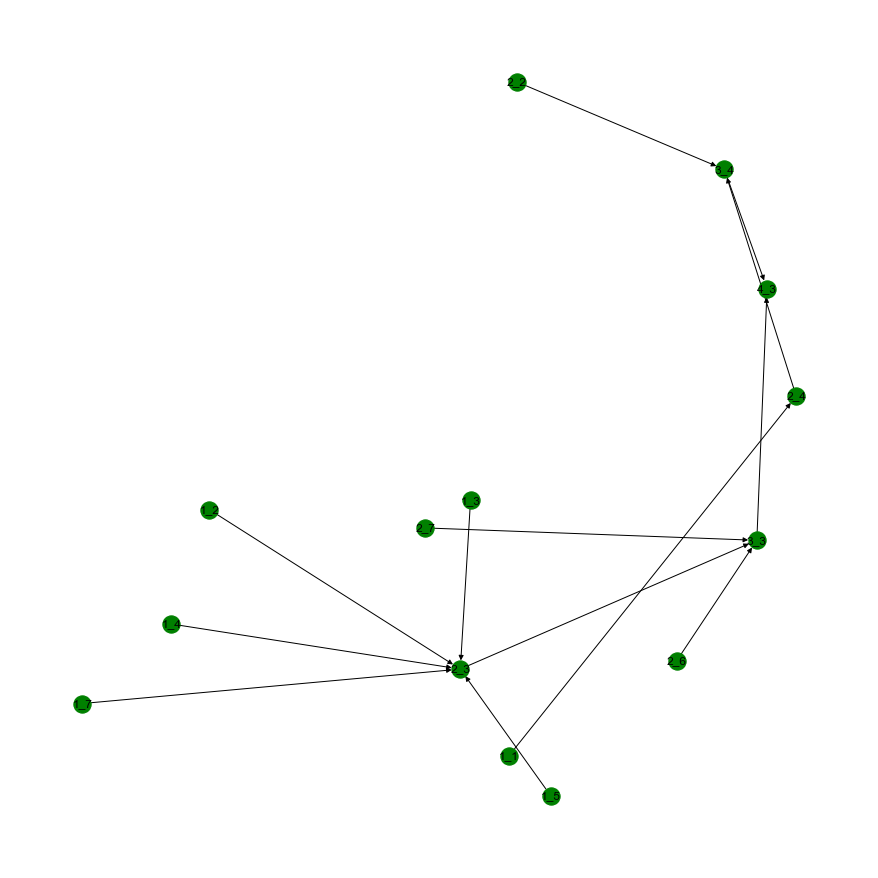

In [187]:
plt.figure(3,figsize=(12,12)) 
nx.draw(x, pos=nx.spring_layout(x), with_labels=True, node_color = "green") 

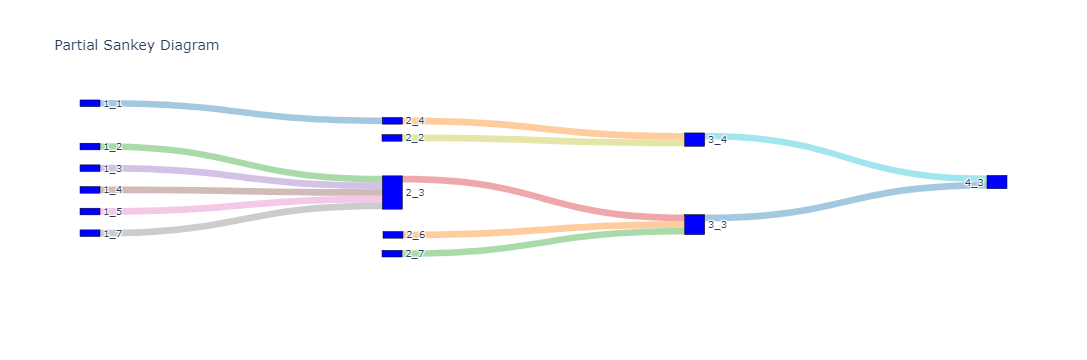

In [188]:
set_color = ['rgba(31, 119, 180, 0.4)', 'rgba(255, 127, 14, 0.4)', 'rgba(44, 160, 44, 0.4)', 'rgba(214, 39, 40, 0.4)', 'rgba(148, 103, 189, 0.4)', 'rgba(140, 86, 75, 0.4)',
             'rgba(227, 119, 194, 0.4)', 'rgba(127, 127, 127, 0.4)', 'rgba(188, 189, 34, 0.4)', 'rgba(23, 190, 207, 0.4)', 'rgba(31, 119, 180, 0.4)', 'rgba(255, 127, 14, 0.4)',
             'rgba(44, 160, 44, 0.4)', 'rgba(214, 39, 40, 0.4)', 'rgba(148, 103, 189, 0.4)', 'rgba(140, 86, 75, 0.4)', 'rgba(227, 119, 194, 0.4)', 'rgba(127, 127, 127, 0.4)',
             'rgba(188, 189, 34, 0.4)', 'rgba(23, 190, 207, 0.4)', 'rgba(31, 119, 180, 0.4)', 'rgba(255, 127, 14, 0.4)', 'rgba(44, 160, 44, 0.4)', 'rgba(214, 39, 40, 0.4)', 
             'rgba(148, 103, 189, 0.4)', 'rgba(140, 86, 75, 0.4)', 'rgba(227, 119, 194, 0.4)', 'rgba(127, 127, 127, 0.4)', 'rgba(188, 189, 34, 0.4)', 'rgba(23, 190, 207, 0.4)',
             'rgba(31, 119, 180, 0.4)', 'rgba(255, 127, 14, 0.4)']
color = []
fig = go.Figure(data=[go.Sankey(
      node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = nodes,
      color = "blue"
    ),
    link = dict(
      source = source,
      target = target,
      value = [1]*len(source),
      color = [cl for cl in set_color]
  ))])

fig.update_layout(title_text="Partial Sankey Diagram ", font_size=10)
fig.show()

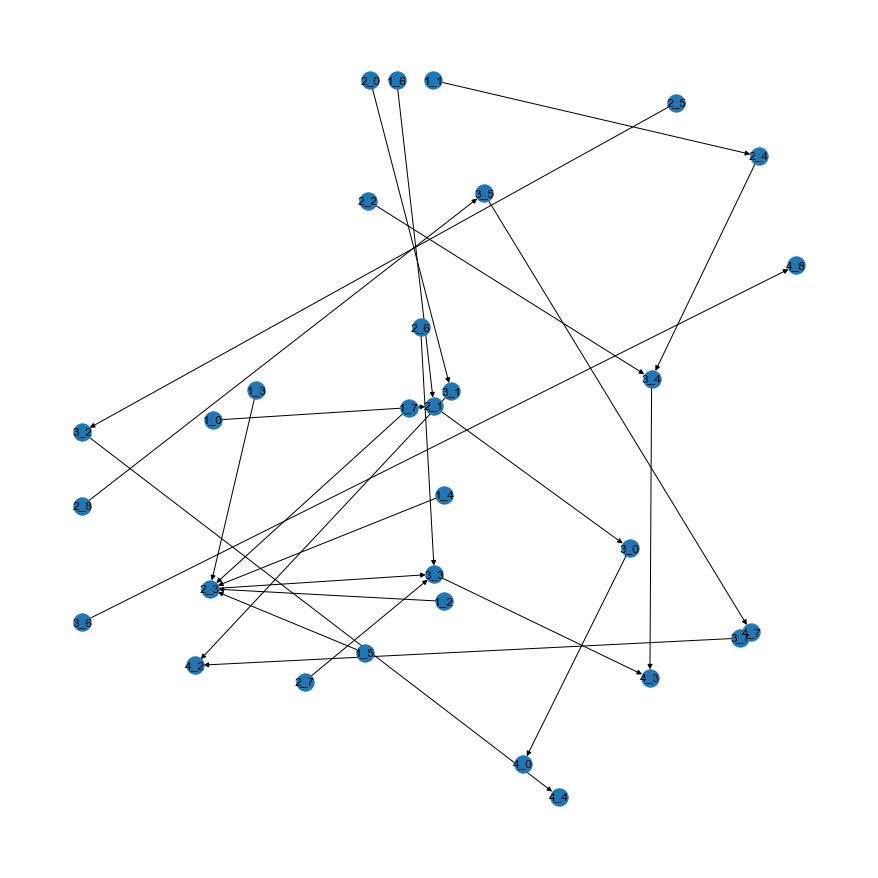

In [189]:
for nodes in nx.weakly_connected_components(com_polytree):
    sub =  com_polytree.subgraph(nodes)    
    plt.figure(3,figsize=(12,12)) 
    nx.draw(sub, pos=nx.spring_layout(sub), with_labels=True) 

In [190]:
y = com_polytree.copy()

In [191]:
nodes = list(y.nodes())

node_pos = [[pos, nodes] for pos, nodes in enumerate(y.nodes)]

source = []
target = []
for s, t in y.edges():
    source.append(s)
    target.append(t)


for i, s in enumerate(source):
    for pos, node in node_pos:
        if s == node:
            source[i] = pos
            break

for i, s in enumerate(target):
    for pos, node in node_pos:
        if s == node:
            target[i] = pos
            break

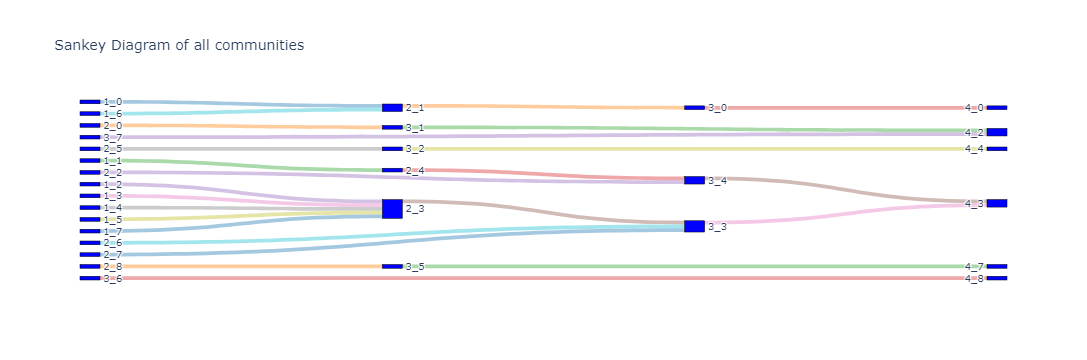

In [193]:
import plotly.graph_objects as go
set_color = ['rgba(31, 119, 180, 0.4)', 'rgba(255, 127, 14, 0.4)', 'rgba(44, 160, 44, 0.4)', 'rgba(214, 39, 40, 0.4)', 'rgba(148, 103, 189, 0.4)', 'rgba(140, 86, 75, 0.4)',
             'rgba(227, 119, 194, 0.4)', 'rgba(127, 127, 127, 0.4)', 'rgba(188, 189, 34, 0.4)', 'rgba(23, 190, 207, 0.4)', 'rgba(31, 119, 180, 0.4)', 'rgba(255, 127, 14, 0.4)',
             'rgba(44, 160, 44, 0.4)', 'rgba(214, 39, 40, 0.4)', 'rgba(148, 103, 189, 0.4)', 'rgba(140, 86, 75, 0.4)', 'rgba(227, 119, 194, 0.4)', 'rgba(127, 127, 127, 0.4)',
             'rgba(188, 189, 34, 0.4)', 'rgba(23, 190, 207, 0.4)', 'rgba(31, 119, 180, 0.4)', 'rgba(255, 127, 14, 0.4)', 'rgba(44, 160, 44, 0.4)', 'rgba(214, 39, 40, 0.4)', 
             'rgba(148, 103, 189, 0.4)', 'rgba(140, 86, 75, 0.4)', 'rgba(227, 119, 194, 0.4)', 'rgba(127, 127, 127, 0.4)', 'rgba(188, 189, 34, 0.4)', 'rgba(23, 190, 207, 0.4)',
             'rgba(31, 119, 180, 0.4)', 'rgba(255, 127, 14, 0.4)']
color = []
fig = go.Figure(data=[go.Sankey(
      node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = nodes,
      color = "blue"
    ),
    link = dict(
      source = source,
      target = target,
      value = [1]*len(source),
      color = [cl for cl in set_color]
  ))])

fig.update_layout(title_text="Sankey Diagram of all communities", font_size=10)
fig.show()

### Vado a recuperare le comunità con i suoi componenti

In [168]:
dict_time_1 = {}
dict_time_2 = {}
dict_time_3 = {}
dict_time_4 = {}
lista_dict = [dict_time_1, dict_time_2, dict_time_3, dict_time_4]

for i in tc.get_observation_ids():                          #id dei cluster temporali
    community = []                        
    diz_comm = tc.get_clustering_at(i).named_communities    #ottengo le comunità in quei cluster temporali
    for j, el in enumerate(diz_comm):                 
        community.append(diz_comm[el])                       #con el prendo il nome della comunità e poi gli attribuisco gli elementi
        dizionario = lista_dict[i-1]
        dizionario[el] = community[j]                        #attribuisco le comunità al dizionario di riferimento

Prendo due (o più) comunità e faccio un match cross_time degli utenti al loro interno 

In [169]:
values_1 = []
values_2 = []
for i in dict_time_1.values():
    values_1.append(i)
for i in dict_time_2.values():
    values_2.append(i)

In [170]:
len(set(values_1[0]).intersection(set(values_2[1])))

380

In [171]:
df_S1 = pd.read_csv('../../data_collection/data/RW_Graphs/df_S1.csv')
df_S2 = pd.read_csv('../../data_collection/data/RW_Graphs/df_S2.csv')
df_S3 = pd.read_csv('../../data_collection/data/RW_Graphs/df_S3.csv')
df_S4 = pd.read_csv('../../data_collection/data/RW_Graphs/df_S4.csv')

In [172]:
df_S1['Community'] = 0 * len(df_S1.index)
df_S2['Community'] = 0 * len(df_S2.index)
df_S3['Community'] = 0 * len(df_S3.index)
df_S4['Community'] = 0 * len(df_S4.index)

In [173]:
for index in df_S1.index:
    for k, v in dict_time_1.items():
        if df_S1['User'][index] in v:
            df_S1['Community'][index] = k

In [174]:
for index in df_S2.index:
    for k, v in dict_time_2.items():
        if df_S2['User'][index] in v:
            df_S2['Community'][index] = k

In [175]:
for index in df_S3.index:
    for k, v in dict_time_3.items():
        if df_S3['User'][index] in v:
            df_S3['Community'][index] = k

In [176]:
for index in df_S4.index:
    for k, v in dict_time_4.items():
        if df_S4['User'][index] in v:
            df_S4['Community'][index] = k

In [177]:
df_S1.to_csv('../../data_collection/data/RW_Graphs/df_S1_comm.csv', sep=',', index=False)
df_S2.to_csv('../../data_collection/data/RW_Graphs/df_S2_comm.csv', sep=',', index=False)
df_S3.to_csv('../../data_collection/data/RW_Graphs/df_S3_comm.csv', sep=',', index=False)
df_S4.to_csv('../../data_collection/data/RW_Graphs/df_S4_comm.csv', sep=',', index=False)

### Temporal Trade-Off
Algorithms belonging to the Temporal Trade-off class process iteratively the evolution of the network. Moreover, unlike Instant optimal approaches, they take into account the network and the communities found in the previous step – or n-previous steps – to identify communities in the current one. Dynamic Community Discovery algorithms falling into this category can be described by an iterative process:

- Initialization: find communities for the initial state of the network;
- Update: for each incoming step, find communities at step t using graph at t and past information.

In [31]:
import dynetx as dn
dg = dn.DynGraph()
gg = [G1, G2, G3, G4]
for t, g in enumerate(gg):
    dg.add_interactions_from(g.edges, t=t+1)

In [32]:
tiles_coms = algorithms.tiles(dg, 1)

In [33]:
com_polytree = tiles_coms.lifecycle_polytree()
print(com_polytree)

DiGraph with 140 nodes and 130 edges


In [34]:
matches_tl = tiles_coms.community_matching(jaccard)
matches_tl

[('1_40', '2_31'),
 ('3_3', '4_2'),
 ('3_15', '4_4'),
 ('3_17', '4_4'),
 ('3_18', '4_4'),
 ('3_20', '4_4'),
 ('3_21', '4_4'),
 ('3_22', '4_4'),
 ('3_25', '4_4'),
 ('3_30', '4_4'),
 ('3_31', '4_4'),
 ('3_36', '4_4'),
 ('3_39', '4_4'),
 ('3_41', '4_4'),
 ('3_42', '4_4'),
 ('3_43', '4_4'),
 ('3_45', '4_4'),
 ('3_46', '4_4'),
 ('3_53', '4_4'),
 ('3_58', '4_4'),
 ('3_66', '4_4'),
 ('3_85', '4_4'),
 ('3_88', '4_4'),
 ('3_93', '4_4'),
 ('3_101', '4_4'),
 ('3_112', '4_4'),
 ('3_125', '4_4'),
 ('3_131', '4_4'),
 ('3_132', '4_4'),
 ('3_145', '4_4'),
 ('3_153', '4_4'),
 ('3_154', '4_4'),
 ('3_167', '4_4'),
 ('3_169', '4_4'),
 ('3_177', '4_4'),
 ('3_189', '4_4'),
 ('3_200', '4_4'),
 ('3_211', '4_4'),
 ('3_217', '4_4'),
 ('3_222', '4_4'),
 ('3_224', '4_4'),
 ('3_230', '4_4'),
 ('3_233', '4_4'),
 ('3_238', '4_4'),
 ('3_262', '4_4'),
 ('3_278', '4_4'),
 ('3_281', '4_4'),
 ('3_283', '4_4'),
 ('3_329', '4_4'),
 ('3_350', '4_4'),
 ('3_365', '4_4'),
 ('3_514', '4_4'),
 ('3_529', '4_4'),
 ('3_534', '4_4')

In [35]:
weak_comp = list(nx.weakly_connected_components(com_polytree))[0]
x = com_polytree.copy()
x.remove_nodes_from([n for n in com_polytree.nodes() if n not in weak_comp])

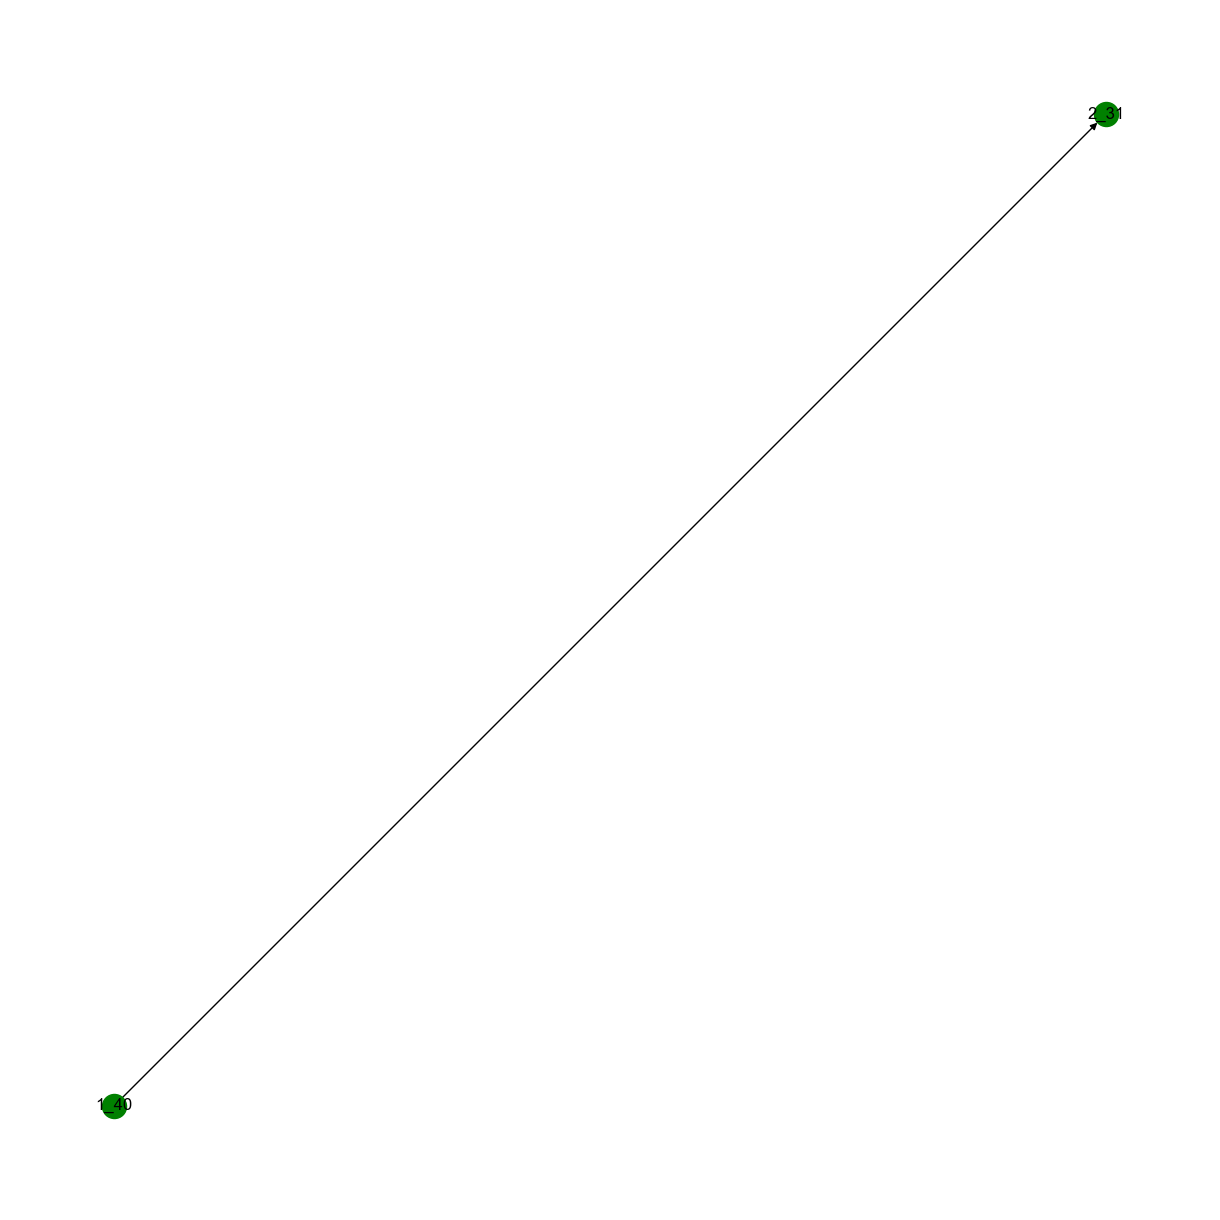

In [36]:
plt.figure(3,figsize=(12,12)) 
nx.draw(x, pos=nx.spring_layout(x), with_labels=True, node_color = "green") 

In [37]:
tiles_coms.clustering_stability_trend(evaluation.nf1)

[0.14451058246211407, 0.2171261429329873, 0.21059380345689105]

Organizzo meglio la collezione delle comunità. Vado praticamente a creare un nuvo dizionario con l'id della comunità e i soggetti che ne appartengono

In [38]:
val = []
keys = []
for key, values in tiles_coms.get_clustering_at(1).named_communities.items():
    val.append(values)
    keys.append(key)

In [39]:
people = []
for dic in val:
    k = []
    for key, values in dic.items():
        if key == '':
            people.append('Empty')
        else:
            k.append(key)
    people.append(k)

In [40]:
new_dict_comm = {}
for i, key in enumerate(keys):
    new_dict_comm[key] = people[i]

In [41]:
val2 = []
keys2 = []
for key, values in tiles_coms.get_clustering_at(2).named_communities.items():
    val2.append(values)
    keys2.append(key)

In [42]:
people2 = []
for dic in val2:
    k = []
    for key, values in dic.items():
        if key == '':
            people2.append('Empty')
        else:
            k.append(key)
    people2.append(k)

In [43]:
new_dict_comm2 = {}
for i, key in enumerate(keys2):
    new_dict_comm2[key] = people2[i]

In [44]:
val3 = []
keys3 = []
for key, values in tiles_coms.get_clustering_at(3).named_communities.items():
    val3.append(values)
    keys3.append(key)

In [45]:
people3 = []
for dic in val3:
    k = []
    for key, values in dic.items():
        if key == '':
            people3.append('Empty')
        else:
            k.append(key)
    people3.append(k)

In [46]:
new_dict_comm3 = {}
for i, key in enumerate(keys3):
    new_dict_comm3[key] = people3[i]

In [47]:
val4 = []
keys4 = []
for key, values in tiles_coms.get_clustering_at(4).named_communities.items():
    val4.append(values)
    keys4.append(key)

In [48]:
people4 = []
for dic in val4:
    k = []
    for key, values in dic.items():
        if key == '':
            people4.append('Empty')
        else:
            k.append(key)
    people4.append(k)

In [49]:
new_dict_comm4 = {}
for i, key in enumerate(keys4):
    new_dict_comm4[key] = people4[i]

Guardo al numero di comunità che ho in ogni t

In [50]:
len(keys)

587

In [51]:
len(keys2)

1040

In [52]:
len(keys3)

1254

In [53]:
len(keys4)

1627